In [1]:
!pip install selenium

   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   -------------- ------------------------- 3.4/9.4 MB 18.3 MB/s eta 0:00:01
   ---------------------------------------  9.2/9.4 MB 25.9 MB/s eta 0:00:01
   ---------------------------------------- 9.4/9.4 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0


In [8]:
!pip install webdriver-manager

In [9]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
from bs4 import BeautifulSoup
import pandas as pd

# Auto-configure ChromeDriver (no paths needed!)
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

base_url = "https://www.cars24.com"

# 1. Load the main page
driver.get(base_url + "/buy-used-cars-delhi-ncr/")
time.sleep(5)

# 2. Parse main page HTML
source_html = driver.page_source
soup = BeautifulSoup(source_html, 'html.parser')

ALL_CAR_URLS = []
link_tags = soup.find_all('a', class_='styles_carCardWrapper__sXLIp')

for link in link_tags:
    href = link.get('href')
    if href:
        full_url = base_url + href if href.startswith('/') else href
        if full_url not in ALL_CAR_URLS:
            ALL_CAR_URLS.append(full_url)

print(f'\nExtracted number of cars: {len(ALL_CAR_URLS)}')

# Lists to hold data
car_names = []
kms = []
fuel_types = []
prices = []  # Changed from 'emis' to more descriptive 'prices'

for car_url in ALL_CAR_URLS:
    driver.get(car_url)
    time.sleep(2)

    car_html = driver.page_source
    car_soup = BeautifulSoup(car_html, 'html.parser')

    # Car Name
    car_name_tag = car_soup.find('h1', class_='sc-braxZu fjhfdl')
    car_name = car_name_tag.text.strip() if car_name_tag else "N/A"

    # KM & Fuel Type
    info_tags = car_soup.find_all('p', class_='sc-braxZu kjFjan') 
    km = "N/A"
    fuel_type = "N/A"
    for tag in info_tags:
        text = tag.text.lower()
        if 'km' in text:
            km = tag.text.strip()
        elif any(fuel in text for fuel in ['petrol', 'diesel', 'cng', 'electric', 'lpg']):
            fuel_type = tag.text.strip()

    # Price (renamed from emi)
    price_tag = car_soup.find('p', class_='sc-braxZu hhzsvw')
    price = price_tag.text.strip() if price_tag else "N/A"

    # Append to lists
    car_names.append(car_name)
    kms.append(km)
    fuel_types.append(fuel_type)
    prices.append(price)

    print(f"Car Name: {car_name}")
    print(f"KM: {km}")
    print(f"Fuel Type: {fuel_type}")
    print(f"Price: {price}")
    print('-' * 40)

# Create DataFrame
data = {
    "Car Name": car_names,
    "KM Driven": kms,
    "Fuel Type": fuel_types,
    "Price": prices
}

df = pd.DataFrame(data)
print("\nFinal DataFrame:\n")
print(df)

df.to_csv("cars24_used_car_data.csv", index=False)

# Close browser
driver.quit()


Extracted number of cars: 20
Car Name: 2018 Datsun Go REMIX EDITION
KM: 90,358 km
Fuel Type: Petrol
Price: ₹2.15 lakh
----------------------------------------
Car Name: 2019 Honda Civic 1.8L I-VTEC V CVT
KM: 77,466 km
Fuel Type: Petrol
Price: ₹9.49 lakh
----------------------------------------
Car Name: 2018 Maruti Swift LXI
KM: 64,571 km
Fuel Type: Petrol
Price: ₹3.99 lakh
----------------------------------------
Car Name: 2022 Maruti Swift VXI
KM: 38,227 km
Fuel Type: CNG
Price: ₹5.65 lakh
----------------------------------------
Car Name: 2024 Tata PUNCH PURE MT
KM: 7,924 km
Fuel Type: Petrol
Price: ₹5.6 lakh
----------------------------------------
Car Name: 2018 Jeep Compass LIMITED PLUS DIESEL
KM: 46,703 km
Fuel Type: Diesel
Price: ₹7.8 lakh
----------------------------------------
Car Name: 2021 Datsun Redi Go A
KM: 22,801 km
Fuel Type: N/A
Price: ₹2.41 lakh
----------------------------------------
Car Name: 2024 Nissan MAGNITE XV AMT EZ Shift DT
KM: 7,563 km
Fuel Type: N/A
Pri

In [11]:
import pandas as pd
import numpy as np
#2. Data Assesment and Cleaning



# Load data
df = pd.read_csv("cars24_used_car_data.csv")


# Clean 'KM Driven' - extract number removing commas
df['KM Driven'] = df['KM Driven'].str.replace(',', '').str.extract(r'(\d+)').astype(float)

# Clean 'Price'  
def price_to_number(price_str):
    if pd.isna(price_str):
        return np.nan   
    price_str = price_str.replace('₹', '').replace(',', '').strip().lower()
    # Check if price contains 'lakh' or 'lac'
    if 'lakh' in price_str or 'lac' in price_str:
        # Extract the numeric part
        num = float(price_str.split()[0])
        return num * 100000  # Converting to lakhs 
    else:
        try:
            return float(price_str)
        except:
            return np.nan

df['Price'] = df['Price'].apply(price_to_number)

# Extract 'Year' extracting the year with 4 digits
df['Year'] = df['Car Name'].str.extract(r'(\d{4})').astype(int) 
df['Brand'] = df['Car Name'].str.split().str[1]
# Standardize 'Fuel Type'
df['Fuel Type'] = df['Fuel Type'].str.strip().str.title()

# Remove outliers
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    return dataframe[(dataframe[column] >= Q1 - 1.5 * IQR) & (dataframe[column] <= Q3 + 1.5 * IQR)]

df = remove_outliers_iqr(df, 'KM Driven')
df = remove_outliers_iqr(df, 'Price')

# Reset index
df.reset_index(drop=True, inplace=True)

df.head()


,Car Name,KM Driven,Fuel Type,Price,Year,Brand
0,2018 Datsun Go REMIX EDITION,90358.0,Petrol,215000.0,2018,Datsun
1,2019 Honda Civic 1.8L I-VTEC V CVT,77466.0,Petrol,949000.0,2019,Honda
2,2018 Maruti Swift LXI,64571.0,Petrol,399000.0,2018,Maruti
3,2022 Maruti Swift VXI,38227.0,Cng,565000.0,2022,Maruti
4,2024 Tata PUNCH PURE MT,7924.0,Petrol,560000.0,2024,Tata


In [12]:
print(df)

                                  Car Name  KM Driven Fuel Type      Price  \
0             2018 Datsun Go REMIX EDITION    90358.0    Petrol   215000.0   
1       2019 Honda Civic 1.8L I-VTEC V CVT    77466.0    Petrol   949000.0   
2                    2018 Maruti Swift LXI    64571.0    Petrol   399000.0   
3                    2022 Maruti Swift VXI    38227.0       Cng   565000.0   
4                  2024 Tata PUNCH PURE MT     7924.0    Petrol   560000.0   
5    2018 Jeep Compass LIMITED PLUS DIESEL    46703.0    Diesel   780000.0   
6                    2021 Datsun Redi Go A    22801.0       NaN   241000.0   
7   2024 Nissan MAGNITE XV AMT EZ Shift DT     7563.0       NaN   745000.0   
8               2021 Tata ALTROZ XT PETROL    73360.0    Petrol   538000.0   
9     2021 Skoda KUSHAQ ACTIVE 1.0L TSI MT    62309.0    Petrol   760000.0   
10          2019 Honda Amaze 1.2L I-VTEC S    33984.0    Petrol   495000.0   
11   2023 KIA SONET HTK PLUS 1.2 PETROL MT    17053.0    Petrol 

C:\Users\Kshitij verma\AppData\Local\Temp\ipykernel_40432\3978337819.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Year', order=sorted(df['Year'].unique()), palette='Set2')


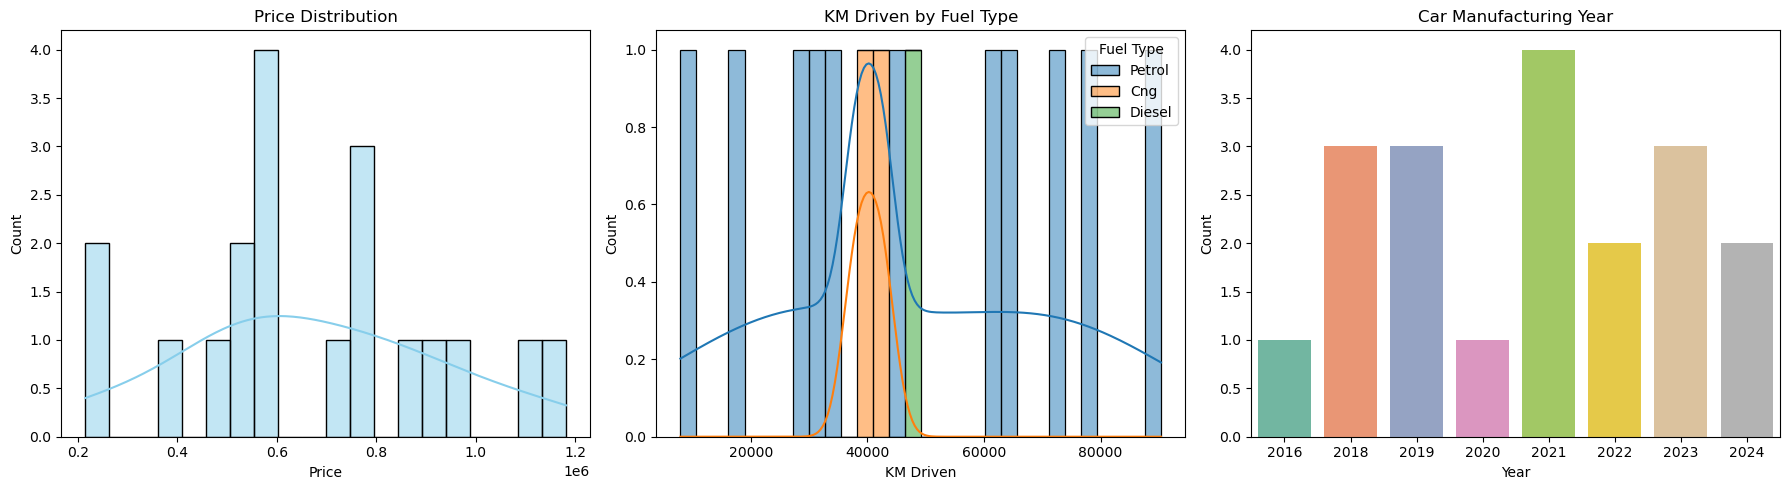

In [13]:
# 3. EDA (exploratory Data Analysis)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 5))

#Univariate Analysis using seaborn and matplotlib.pyplot
plt.subplot(1, 3, 1)
sns.histplot(df['Price'], bins=20, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

#KM Driven by Fuel Type
plt.subplot(1, 3, 2)
sns.histplot(data=df, x='KM Driven', hue='Fuel Type', bins=30, kde=True, multiple="stack")
plt.title('KM Driven by Fuel Type')
plt.xlabel('KM Driven')
plt.ylabel('Count')

#Year Distribution (histogram is not possible as it has discrete data)
plt.subplot(1, 3, 3)
sns.countplot(data=df, x='Year', order=sorted(df['Year'].unique()), palette='Set2')
plt.title('Car Manufacturing Year')
plt.xlabel('Year')
plt.ylabel('Count')

#incorporated all univariate analysis in one format as in the figure
plt.tight_layout()
plt.show()





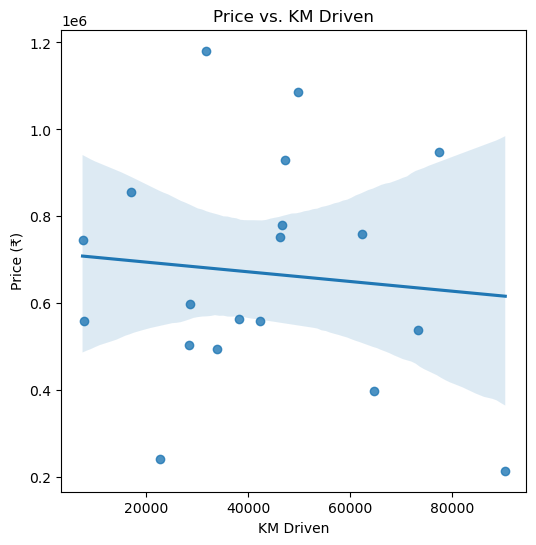

In [14]:
#Price vs Mileage
plt.figure(figsize=(6,6))
sns.regplot(data=df, x='KM Driven', y='Price')
plt.title('Price vs. KM Driven')
plt.xlabel('KM Driven')
plt.ylabel('Price (₹)')
plt.show()


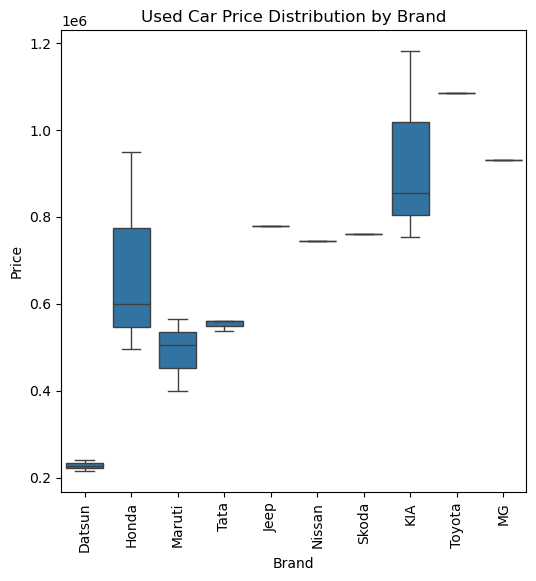

In [15]:
#boxplot of price by brand
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.boxplot(data=df, x='Brand', y='Price')
plt.xticks(rotation=90)
plt.title('Used Car Price Distribution by Brand')
plt.show()


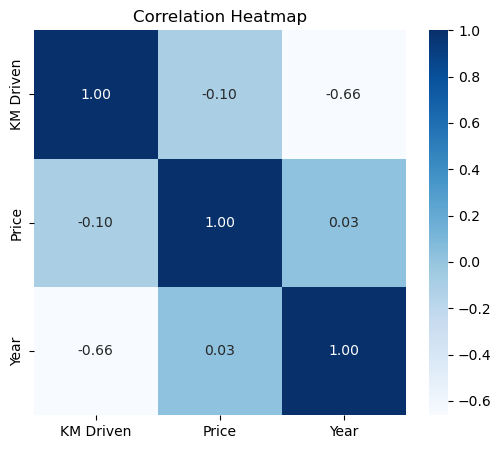

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick numeric columns
numeric_data = df[['KM Driven', 'Price', 'Year']]

# Calculate correlation
correlation = numeric_data.corr()

# Setting figure size
plt.figure(figsize=(6, 5))

#heatmap
sns.heatmap(correlation, annot=True, cmap='Blues', fmt=".2f")

# Title
plt.title("Correlation Heatmap")

# Show plot
plt.show()


In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
#4. Feature Engineering
CURRENT_YEAR = 2025
df['Car Age'] = CURRENT_YEAR - df['Year']

df['price/km']=df['Price']/df['KM Driven']

df.head()

,Car Name,KM Driven,Fuel Type,Price,Year,Brand,Car Age,price/km
0,2018 Datsun Go REMIX EDITION,90358.0,Petrol,215000.0,2018,Datsun,7,2.379424
1,2019 Honda Civic 1.8L I-VTEC V CVT,77466.0,Petrol,949000.0,2019,Honda,6,12.250536
2,2018 Maruti Swift LXI,64571.0,Petrol,399000.0,2018,Maruti,7,6.179245
3,2022 Maruti Swift VXI,38227.0,Cng,565000.0,2022,Maruti,3,14.780129
4,2024 Tata PUNCH PURE MT,7924.0,Petrol,560000.0,2024,Tata,1,70.671378


In [19]:
# Import necessary tools
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd


categorical_cols = ['Brand', 'Fuel Type']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

df_without_cats = df.drop(columns=categorical_cols).reset_index(drop=True)
df_encoded = pd.concat([df_without_cats, encoded_df], axis=1)

numeric_cols = ['KM Driven', 'Price', 'Car Age']

scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print(df_encoded.head())


                             Car Name  KM Driven     Price  Year   Car Age  \
0        2018 Datsun Go REMIX EDITION   2.119371 -1.788262  2018  1.180480   
1  2019 Honda Civic 1.8L I-VTEC V CVT   1.542860  1.101553  2019  0.731898   
2               2018 Maruti Swift LXI   0.966214 -1.063840  2018  1.180480   
3               2022 Maruti Swift VXI  -0.211850 -0.410285  2022 -0.613850   
4             2024 Tata PUNCH PURE MT  -1.566956 -0.429970  2024 -1.511015   

    price/km  Brand_Datsun  Brand_Honda  Brand_Jeep  Brand_KIA  Brand_MG  \
0   2.379424           1.0          0.0         0.0        0.0       0.0   
1  12.250536           0.0          1.0         0.0        0.0       0.0   
2   6.179245           0.0          0.0         0.0        0.0       0.0   
3  14.780129           0.0          0.0         0.0        0.0       0.0   
4  70.671378           0.0          0.0         0.0        0.0       0.0   

   Brand_Maruti  Brand_Nissan  Brand_Skoda  Brand_Tata  Brand_Toyota  \
0 

In [102]:
from sklearn.preprocessing import StandardScaler


numeric_cols = ['KM Driven', 'Price', 'Car Age']


scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


df_encoded.head()


,Car Name,KM Driven,Price,Year,Car Age,price/km,Brand_Datsun,Brand_Honda,Brand_Jeep,Brand_KIA,...,Brand_Maruti,Brand_Nissan,Brand_Skoda,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Fuel Type_Cng,Fuel Type_Diesel,Fuel Type_Petrol,Fuel Type_nan
0,2018 Datsun Go REMIX EDITION,2.130451,-1.608486,2018,0.816865,2.379424,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2021 Mahindra Thar LX PETROL HT 4WD AT,-0.589982,1.439068,2021,-0.322947,44.582019,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2022 Maruti Swift VXI,-0.062342,-0.461557,2022,-0.702884,14.780129,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2024 Tata PUNCH PURE MT,-1.336981,-0.477942,2024,-1.462758,70.671378,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2021 MG HECTOR SHARP 1.5 PETROL CVT,1.679997,1.484945,2021,-0.322947,14.551344,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Define numeric columns to scale
numeric_cols = ['KM Driven', 'Price', 'Car Age']

# apply MinMaxScaler
minmax_scaler = MinMaxScaler()
df_encoded[numeric_cols] = minmax_scaler.fit_transform(df_encoded[numeric_cols])
df_encoded.head()

,Car Name,KM Driven,Price,Year,Car Age,price/km,Brand_Datsun,Brand_Honda,Brand_Jeep,Brand_KIA,Brand_MG,Brand_Maruti,Brand_Nissan,Brand_Skoda,Brand_Tata,Brand_Toyota,Fuel Type_Cng,Fuel Type_Diesel,Fuel Type_Petrol,Fuel Type_nan
0,2018 Datsun Go REMIX EDITION,1.000000,0.000000,2018,0.750,2.379424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2019 Honda Civic 1.8L I-VTEC V CVT,0.844290,0.759834,2019,0.625,12.250536,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018 Maruti Swift LXI,0.688544,0.190476,2018,0.750,6.179245,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2022 Maruti Swift VXI,0.370361,0.362319,2022,0.250,14.780129,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2024 Tata PUNCH PURE MT,0.004360,0.357143,2024,0.000,70.671378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
